# **CSCA 5622 Supervised Learning Final Project - Salaries inf Data Science**

Here follows the list of all libraries used.

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from math import floor
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

# Loading the Datasets

In [35]:
# import the big dataset
df = pd.read_csv('/kaggle/input/datascience-salaries-2024/DataScience_salaries_2024.csv')

We can inspect the data by using .info() and .describe(). In the meanwhile, we also want to perform some data cleaning.

In [3]:
print(df.head(15))
print(df.columns) #['work_year', 'experience_level', 'employment_type', 'job_title',
#'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
#'remote_ratio', 'company_location', 'company_size']
print(df.info())
print(df.describe())
print("null",df.isnull().sum())

print(df['job_title'].unique())
print(df['experience_level'].unique())
print(df['employment_type'].unique())
print(df['company_location'].unique())
print(df['company_size'].unique())

    work_year experience_level employment_type  \
0        2021               MI              FT   
1        2021               MI              FT   
2        2020               MI              FT   
3        2021               MI              FT   
4        2022               SE              FT   
5        2021               MI              FT   
6        2021               SE              FT   
7        2022               EN              FT   
8        2022               EX              FT   
9        2022               EN              FT   
10       2023               MI              FT   
11       2023               EN              FT   
12       2021               SE              FT   
13       2022               SE              FT   
14       2020               EN              FT   

                         job_title    salary salary_currency  salary_in_usd  \
0                   Data Scientist  30400000             CLP          40038   
1                  BI Data Analyst  11000

# Cleaning the Data
We can tell that there are 11 columns, which are ['work_year', 'experience_level', 'employment_type', 'job_title', 'salary', 'salary_currency', 'salary_in_usd', 'employee_residence', 'remote_ratio', 'company_location', 'company_size'].Our goal is to predict salary in USD with the relevant columns. It is noted that experience_level, employment_type, job_title, salary_currency, employee_residence,company_location and company_size are all categorical data, while work_year and remote_ratio are numeric. The column salary_in_usd should be chosen as the column for y, as we want to unify the units; therefore, the column salary is to be dropped.

Also noting that some columns are typed as objects, we need to conver them to strings.

In [4]:
cols=df.columns.tolist()
if 'salary' in cols:
    df = df.drop('salary', axis=1)

categs = ['experience_level', 'employment_type', 'job_title', 'salary_currency', 'employee_residence', 'company_location', 'company_size']
for cat in categs:
    print(cat)
    df[cat]=df[cat].astype(str)
df.info()

experience_level
employment_type
job_title
salary_currency
employee_residence
company_location
company_size
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14838 entries, 0 to 14837
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           14838 non-null  int64 
 1   experience_level    14838 non-null  object
 2   employment_type     14838 non-null  object
 3   job_title           14838 non-null  object
 4   salary_currency     14838 non-null  object
 5   salary_in_usd       14838 non-null  int64 
 6   employee_residence  14838 non-null  object
 7   remote_ratio        14838 non-null  int64 
 8   company_location    14838 non-null  object
 9   company_size        14838 non-null  object
dtypes: int64(3), object(7)
memory usage: 1.1+ MB


# Choosing the Prominent Components
Since there are too many features for the moment; we would like to carry out PCA to determine the prominent features. To begin with, we can use the covariance matrix on the numeric columns to see how those columns are related to each other.

               work_year  salary_in_usd  remote_ratio
work_year       1.000000       0.090873     -0.204954
salary_in_usd   0.090873       1.000000     -0.064829
remote_ratio   -0.204954      -0.064829      1.000000


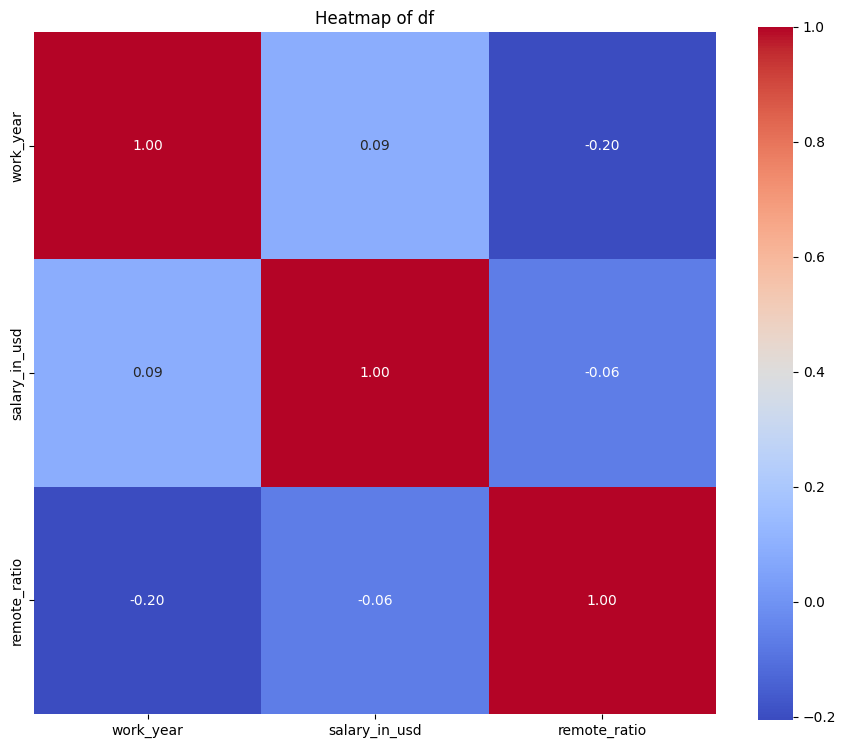

               work_year  salary_in_usd  remote_ratio
work_year       1.000000      -0.094154      0.381385
salary_in_usd  -0.094154       1.000000     -0.550971
remote_ratio    0.381385      -0.550971      1.000000


In [47]:
nums = ['work_year', 'salary_in_usd', 'remote_ratio']
print(df[nums].corr())

plt.figure(figsize=(11, 9))
sns.heatmap(df[nums].corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Heatmap of df')
plt.show()

print(df[df['company_location'] == 'JP'][nums].corr())

From the covariance table, it is observed that work_year and remote_ratio are not quite related to the salary when the location is not specified. From the heatmap, we should visualize the same result. 

When for example, we limit the company to "JP", the correlation seems to be higher between the columns. Let's carry out a more in-depths analysis. We can carry out a PCA procedure and see which columns are more influential in each PCA. Since the influence is measured by the absolute value, we will print out the top 3 and the bottom 3 features for each PCA. 

In [36]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

#df=df[df['company_location'] == 'JP']

categs = ['experience_level', 'employment_type'
          #, 'job_title'
          #, 'salary_currency', 
          #'employee_residence'
          , 'company_location', 'company_size']
nums = ['work_year', 'salary_in_usd', 'remote_ratio']

preproc = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), nums),  
        ('cat', OneHotEncoder(sparse_output=False), categs)
    ]
)
pl = Pipeline(steps=[
    ('preprocessor', preproc),
    ('pca', PCA(n_components=3))
])

pca= pl.fit_transform(df)
pca_df = pd.DataFrame(data=pca, columns=[f'PC{i+1}' for i in range(pca.shape[1])])


pca_comp = pl.named_steps['pca'].components_
all_cols_after_one_hot = nums + list(preproc.named_transformers_['cat'].get_feature_names_out(categs))
df2 = pd.DataFrame(data=pca_comp, columns=all_cols_after_one_hot).drop('salary_in_usd',axis=1)

top3=[]
btm3=[]
for i,r in df2.iterrows():
    top3.append(r.nlargest(3))
    btm3.append(r.nsmallest(3))
print(top3)
print(btm3)

[work_year              0.650091
company_location_US    0.075476
company_size_M         0.058128
Name: 0, dtype: float64, remote_ratio           0.355858
experience_level_SE    0.196020
company_location_US    0.079988
Name: 1, dtype: float64, company_size_L         0.048018
experience_level_SE    0.041883
company_size_S         0.010273
Name: 2, dtype: float64]
[remote_ratio          -0.612309
company_size_L        -0.037541
experience_level_EN   -0.022741
Name: 0, dtype: float64, work_year             -0.263805
experience_level_MI   -0.141048
experience_level_EN   -0.070113
Name: 1, dtype: float64, remote_ratio     -0.705128
work_year        -0.700027
company_size_M   -0.058291
Name: 2, dtype: float64]


# Finalizing the Preprocessing and Splitting Data into Train and Test
With the above analysis, I can decide that the experience, company size and company location are the three principal features that impact the salary. They are all categorical data, which means we have to carry out the one hot process to turn them into different columns; and after that process, we can try different supervised learning algorithms to fit the model.

In the following code, we will select the preditors into X and the predicted variable which is the salary in USD into y. Remembering that all the three predictors chosen are categorical, we must apply the one hot precedure first, while we might also want to scale the data for y. Finally, we will split the data into train data and test data.

In [37]:
from sklearn.model_selection import train_test_split, GridSearchCV
cols_chosen=['experience_level','company_size','company_location']
col_x=['experience_level','company_size','company_location'#,'salary_in_usd'
      ]
col_y=['salary_in_usd']

X=df[col_x]
y=df[col_y]

preprocx = ColumnTransformer(
    transformers=[ 
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), col_x)
    ]
)

preprocy = ColumnTransformer(
    transformers=[ 
       ('num', StandardScaler(), col_y)
    ]
)

X2 = preprocx.fit_transform(X)
y2 = preprocy.fit_transform(y)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)
y_train2 = y_train2.ravel()
y_test2 = y_test2.ravel()
print(y_test2.shape,X_test2.shape,X_train2.shape)

(2968,) (2968, 84) (11870, 84)


# Building and Fitting Different Models
We now want to test different models we have learnt in this course to fit the data and predict the salaries. 

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

print(X_train2,X_train2.shape,y_train2,y_train2.shape,X_test2.shape,y_test2.shape)

# LR
model=LinearRegression()
model.fit(X_train2, y_train2)
y_pred_train2 = model.predict(X_train2)
y_pred_test2=model.predict(X_test2)
mse_train2 = mean_squared_error(y_train2, y_pred_train2)
mse_test2 = mean_squared_error(y_test2, y_pred_test2)
r2_test2 = r2_score(y_test2, y_pred_test2)
r2_train2 = r2_score(y_train2, y_pred_train2)
print(r2_test2,r2_train2)


# Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train2, y_train2)
y_pred_train2 = model.predict(X_train2)
y_pred_test2=model.predict(X_test2)
mse_train2 = mean_squared_error(y_train2, y_pred_train2)
mse_test2 = mean_squared_error(y_test2, y_pred_test2)
r2_test2 = r2_score(y_test2, y_pred_test2)
r2_train2 = r2_score(y_train2, y_pred_train2)
print(r2_test2,r2_train2)

# SVR
model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
model.fit(X_train2, y_train2)
y_pred_train2 = model.predict(X_train2)
y_pred_test2=model.predict(X_test2)
mse_train2 = mean_squared_error(y_train2, y_pred_train2)
mse_test2 = mean_squared_error(y_test2, y_pred_test2)
r2_test2 = r2_score(y_test2, y_pred_test2)
r2_train2 = r2_score(y_train2, y_pred_train2)
print(r2_test2,r2_train2)

# Decision Tree
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train2, y_train2)
y_pred_train2 = model.predict(X_train2)
y_pred_test2=model.predict(X_test2)
mse_train2 = mean_squared_error(y_train2, y_pred_train2)
mse_test2 = mean_squared_error(y_test2, y_pred_test2)
r2_test2 = r2_score(y_test2, y_pred_test2)
r2_train2 = r2_score(y_train2, y_pred_train2)
print(r2_test2,r2_train2)

# Gradient Boosting
model = GradientBoostingRegressor(n_estimators=100, random_state=42)
model.fit(X_train2, y_train2)
y_pred_train2 = model.predict(X_train2)
y_pred_test2=model.predict(X_test2)
mse_train2 = mean_squared_error(y_train2, y_pred_train2)
mse_test2 = mean_squared_error(y_test2, y_pred_test2)
r2_test2 = r2_score(y_test2, y_pred_test2)
r2_train2 = r2_score(y_train2, y_pred_train2)
print(r2_test2,r2_train2)


[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 1. 0. 0.]
 ...
 [0. 0. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]] (11870, 84) [-1.76034275 -0.4039413   0.14672863 ...  0.2191852   1.59586
 -0.08513239] (11870,) (2968, 84) (2968,)
-3.220843152060163e+21 0.205581393293104
0.19616182861850806 0.21325699679120858
0.16719895949572772 0.18962541507499386
0.19927411442781506 0.21402048324906087
0.19542187420953538 0.20696349330411057


Among all the models, random forest regressor has a decent r2 score, despite the fact that all of the models yield results somehow bad. Maybe we can change the train data size to improve the predictions.

In [41]:
for i in range(10):
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.005+(i)*0.005, random_state=42)
    y_train2 = y_train2.ravel()
    y_test2 = y_test2.ravel()
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train2, y_train2)
    y_pred_train2 = model.predict(X_train2)
    y_pred_test2=model.predict(X_test2)
    mse_train2 = mean_squared_error(y_train2, y_pred_train2)
    mse_test2 = mean_squared_error(y_test2, y_pred_test2)
    r2_test2 = r2_score(y_test2, y_pred_test2)
    r2_train2 = r2_score(y_train2, y_pred_train2)
    print(r2_test2,r2_train2)


0.1941078381249065 0.21631261772816268
0.26055452406731605 0.21566730520381705
0.24364159265553476 0.2157217124821298
0.2879798771779679 0.21401673039134128
0.28585148971419494 0.21402353294966692
0.2832763586148752 0.2138074294531147
0.2695278560737756 0.21395489831130232
0.2580001832037696 0.21391733636398214
0.2569107735002092 0.21382705641913846
0.25297937300050544 0.21416690386693849


It seems that when i=6, i.e. test_size=0.035, the r2_score is highest for test data. Therefore, we will split the data with this new ratio and following that, we will now try to tune the parameters using grid search.

In [45]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.035, random_state=42)
y_train2 = y_train2.ravel()
y_test2 = y_test2.ravel()


"""
rf = RandomForestRegressor(random_state=42)
grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 
                  10
                  , 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
gridSearch = GridSearchCV(estimator=rf, param_grid=grid, 
                     cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)
gridSearch.fit(X_train2, y_train2)
bestEstimator = gridSearch.best_estimator_
y_pred2 = bestEstimator.predict(X_test2)
mse2 = mean_squared_error(y_test2, y_pred2)
print(gridSearch.best_params_,gridSearch.best_score_, mse2)
"""
# running the code above, we obtain the following parameters
#{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}

"\nrf = RandomForestRegressor(random_state=42)\ngrid = {\n    'n_estimators': [50, 100, 200],\n    'max_depth': [None, \n                  10\n                  , 20, 30],\n    'min_samples_split': [2, 5, 10],\n    'min_samples_leaf': [1, 2, 4]\n}\ngridSearch = GridSearchCV(estimator=rf, param_grid=grid, \n                     cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)\ngridSearch.fit(X_train2, y_train2)\nbestEstimator = gridSearch.best_estimator_\ny_pred2 = bestEstimator.predict(X_test2)\nmse2 = mean_squared_error(y_test2, y_pred2)\nprint(gridSearch.best_params_,gridSearch.best_score_, mse2)\n"

Summarizing what is above, we put in the best parameters with the best test size and we carry out one more time of regression.

In [44]:

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.35, random_state=42)
y_train2 = y_train2.ravel()
y_test2 = y_test2.ravel()
model = RandomForestRegressor(max_depth=20, min_samples_leaf= 2, min_samples_split=10, n_estimators=100)
model.fit(X_train2, y_train2)
y_pred_train2 = model.predict(X_train2)
y_pred_test2=model.predict(X_test2)
mse_train2 = mean_squared_error(y_train2, y_pred_train2)
mse_test2 = mean_squared_error(y_test2, y_pred_test2)
r2_test2 = r2_score(y_test2, y_pred_test2)
r2_train2 = r2_score(y_train2, y_pred_train2)
print(r2_test2,r2_train2)

0.19772228435727635 0.20946689516884465


As a conclusion, for the dataset, random forest with the following parameters yields the best result:
max_depth=20, min_samples_leaf= 2, min_samples_split=10, n_estimators=100max_depth=20, min_samples_leaf= 2, min_samples_split=10, n_estimators=100

Since we have 3 categorical columns which lead to a total of 80+ features after the one hot procedure, I think the model suffers from overfitting. As a result, the r2 score is not ideal for the test data.